In [1]:
library(ggplot2)
library(data.table)
theme_set(theme_bw())
library(patchwork)
# library(ggpubr)

In [2]:
# setwd('~/m/msingle/mess/124_singlem-benchmarking')

In [3]:
# from plot.ipynb in folder 2
novelty_benchmark_results = fread('2_phylogenetic_novelty/bray_curtis.tsv')
table(novelty_benchmark_results$tool)


    kaiju    kraken     map2b  metabuli metaphlan     motus   singlem  sourmash 
      840       840       840       840       840       840       840       840 

In [4]:
tools = c('singlem', 'metaphlan', 'motus', 'kraken', 'sourmash', 'kaiju', 'map2b', 'metabuli')
# Tools that do not have the correct taxonomy are tested only at the domain level. eg. Kaiju has NCBI taxonomy and MAP2B uses GTDB v202, mOTUs sometimes has incompatible strings
correct_taxonomy_tools = c('singlem', 'metaphlan', 'kraken', 'sourmash', 'metabuli')

publication_names = data.table(
    tool = tools,
    publication_name = c('SingleM', 'MetaPhlAn', 'mOTUs', 'Kraken2', 'sourmash', 'Kaiju', 'MAP2B', 'Metabuli')
)

tools2_order = publication_names$publication_name
name_to_publication_name = function(names, correct_taxonomy_only=F){
    to_return = c()
    for (name in names){
        to_return = c(to_return, publication_names[tool==name]$publication_name)
    }
    if (correct_taxonomy_only){
        return(factor(to_return, levels=publication_names[tool %in% correct_taxonomy_tools]$publication_name))
    } else {
        return(factor(to_return, levels=publication_names$publication_name))
    }
}

correct_taxonomy_tools_publication_names = name_to_publication_name(correct_taxonomy_tools)

In [5]:
orders = c('kingdom','phylum','class','order','family','genus','species')
novelty_benchmark_results[, rank := factor(rank, levels=orders)]
novelty_benchmark_results[, novelty_category := factor(novelty_category, levels=orders)]

novelty_benchmark_results[, tool := factor(tool, levels=tools)]
novel_orders = gsub('^','novel ',orders)
novelty_benchmark_results[, novelty_category_novel := factor(novelty_category_novel, levels=novel_orders)]

Warning message:
“`qplot()` was deprecated in ggplot2 3.4.0.”


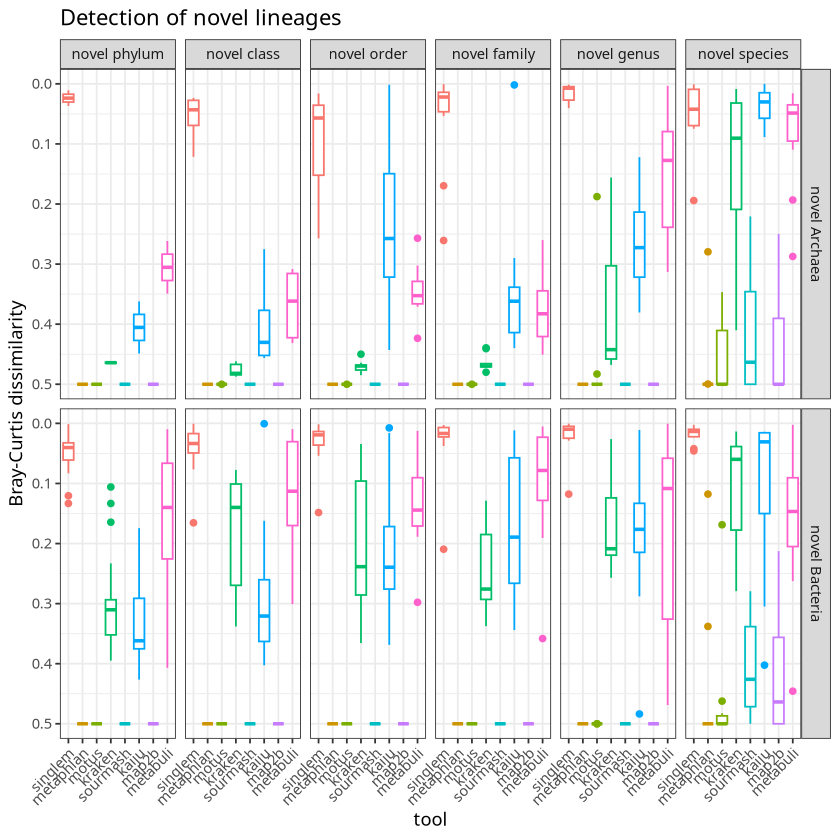

In [6]:
qplot(data=novelty_benchmark_results[rank=='kingdom'], tool, value, geom='boxplot', main='Detection of novel lineages', colour=tool, ylab='Bray-Curtis dissimilarity')+facet_grid(kingdom~novelty_category_novel)+theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_y_reverse()

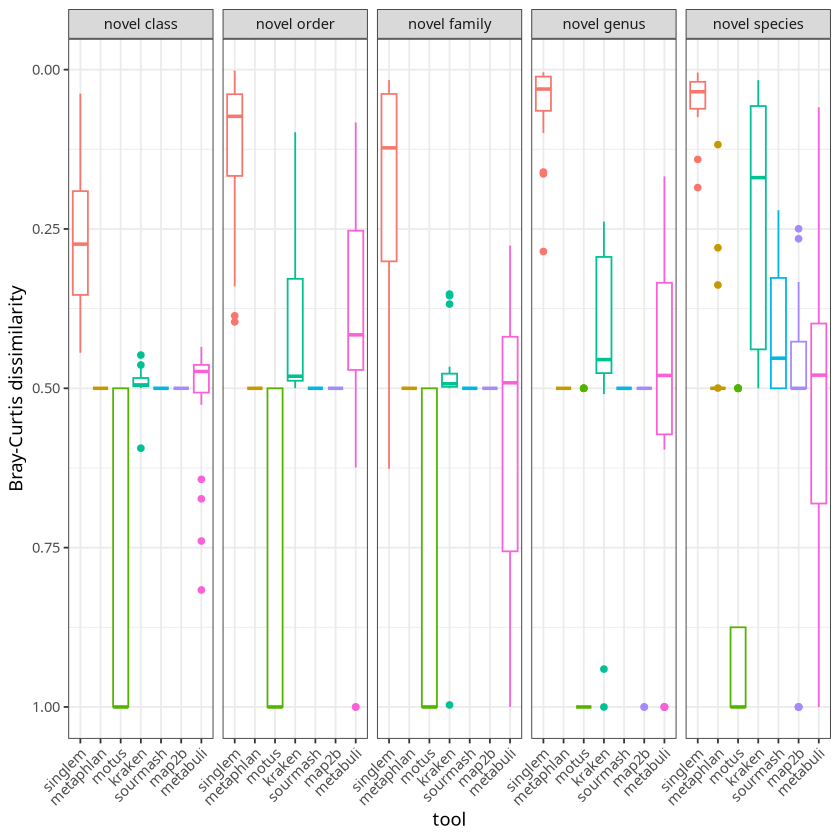

In [7]:
# What about when the rank equals one level above the novelty category?

# novelty_benchmark_results
# novelty_benchmark_results[tool != 'kaiju'][novelty_category != 'phylum'][rank==orders[as.numeric(novelty_category)-1]]
qplot(data=novelty_benchmark_results[tool != 'kaiju'][novelty_category != 'phylum'][rank==orders[as.numeric(novelty_category)-1]], colour=tool, ylab='Bray-Curtis dissimilarity', tool, value, geom='boxplot')+facet_grid(.~novelty_category_novel)+theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_y_reverse()

In [8]:
# Read non-novelty results
marine = fread('1_novel_strains/accuracy_results.csv')
marine[0:3]

tool,community,rank,metric,value
<chr>,<chr>,<chr>,<chr>,<dbl>
singlem,marine0,kingdom,Bray-Curtis distance,0.001896759
singlem,marine0,phylum,Bray-Curtis distance,0.012855254
singlem,marine0,class,Bray-Curtis distance,0.014339314


In [9]:
# Average F1 at the species level for each tool
marine[rank=='species' & metric %in% c('F1 score','Completeness'), mean(value), by=list(tool,metric)]

tool,metric,V1
<chr>,<chr>,<dbl>
singlem,Completeness,0.86173977
singlem,F1 score,0.89900783
metaphlan,Completeness,0.78993182
metaphlan,F1 score,0.84221607
kraken,Completeness,0.98763113
kraken,F1 score,0.24226397
sourmash,Completeness,0.58794675
sourmash,F1 score,0.72972254
metabuli,Completeness,0.48962947


In [10]:
runtimes = fread('1_novel_strains/runtime.csv')
runtimes[0:3]

tool,threads,community,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time
<chr>,<int>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
singlem,1,marine0,2020.808,0:33:40,1818.44,4631.19,1763.02,1768.85,1.23,554.79,87.10,1783.89
metaphlan,1,marine0,9616.442,2:40:16,17546.19,19003.83,17501.14,17501.49,3477.22,116.39,199.18,19155.15
kraken,1,marine0,1250.033,0:20:50,294838.16,294854.43,294832.23,294832.37,295299.61,0.01,93.10,1163.75


In [11]:
novelty_benchmark_results[, tool2 := name_to_publication_name(tool)]
marine[, tool2 := tool]
runtimes[, tool2 := name_to_publication_name(tool)]

my_colours = c(
#1b9e77 Dark2
#d95f02
#7570b3
#e7298a
#66a61e
#e6ab02
#a6761d
#666666
'#e7298a',
'#1b9e77',
'#d95f02',
'#7570b3',
'#66a61e',
'#e6ab02',
'#a6761d',
'#666666'

#     '#e7298a','#1b9e77', #?
# '#d95f02',
# '#7570b3',

# '#66a61e',
# '#e6ab02'
)
options(repr.plot.width=7, repr.plot.height=10)

# library(ggbreak)
runtimes2 = runtimes[threads==1, .(mins=mean(s/60), max_rss=mean(max_rss/1000)), by=.(tool2)]

In [12]:
# ggbreak doesn't get applied so can't use ggarrange


# rp = qplot(data=runtimes2, xlab='', tool2, mins, geom='col', fill=tool2, ylab='Runtime (mins)') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_fill_manual(breaks=tools2_order, values=my_colours)+scale_y_break(c(750,6200))

# library(patchwork)

# ggarrange(
#     qplot(data=novelty_benchmark_results[rank=='kingdom'], xlab='', tool2, value, geom='boxplot', colour=tool2, ylab='Bray-Curtis dissimilarity')+facet_grid(kingdom~novelty_category_novel)+theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none') +scale_color_manual(breaks=tools2_order, values=my_colours)+scale_y_reverse(),

#     qplot(data=novelty_benchmark_results[tool != 'kaiju'][rank==orders[as.numeric(novelty_category)-1]], colour=tool2, ylab='Dissimilarity', tool2, value, xlab='', geom='boxplot')+facet_grid(.~novelty_category_novel)+theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_y_reverse() +scale_color_manual(breaks=tools2_order, values=my_colours),

#     ggarrange(
#         qplot(data=marine[rank=='species'], xlab='', ylim=c(0.6,0), tool2, value, geom='boxplot', colour=tool2, ylab='Dissimilarity') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_color_manual(breaks=tools2_order, values=my_colours),

#         rp,

#         qplot(data=runtimes[threads==1], xlab='', tool2, max_rss/1000, geom='boxplot', colour=tool2, ylab='Memory (GB)') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_color_manual(breaks=tools2_order, values=my_colours),

#         labels=c('C','D','E'),
#         nrow=1
#     ),

#     nrow=3,
#     labels=c('A','B'),
#     heights=c(2,1.2,1.2)
# )

In [13]:
runtimes[, mean(s/60), by=tool2]

tool2,V1
<fct>,<dbl>
SingleM,34.11267
MetaPhlAn,150.13279
Kraken2,20.35392
sourmash,56.58704
Metabuli,78.64262


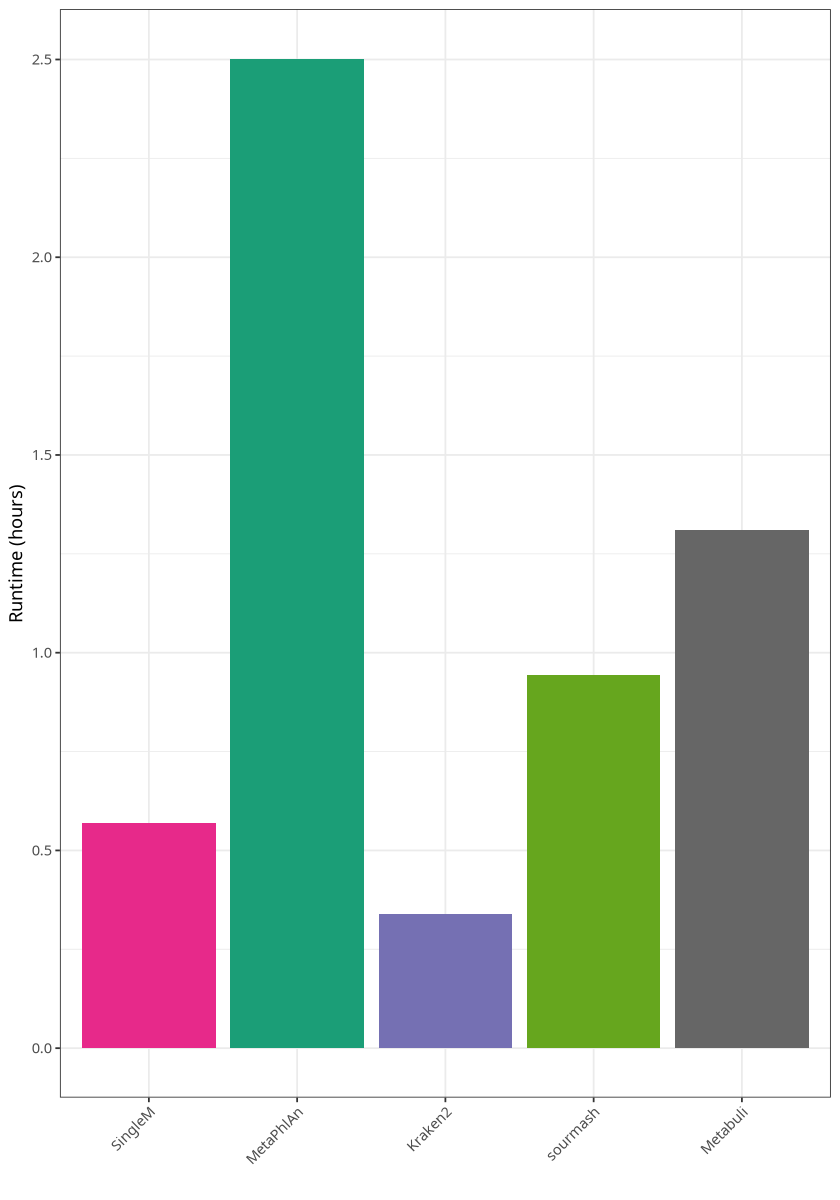

In [14]:
qplot(data=runtimes2[tool2 %in% correct_taxonomy_tools_publication_names], xlab='', tool2, mins/60, geom='col', fill=tool2, ylab='Runtime (hours)') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_fill_manual(breaks=tools2_order, values=my_colours)#+scale_y_break(c(750,6200))

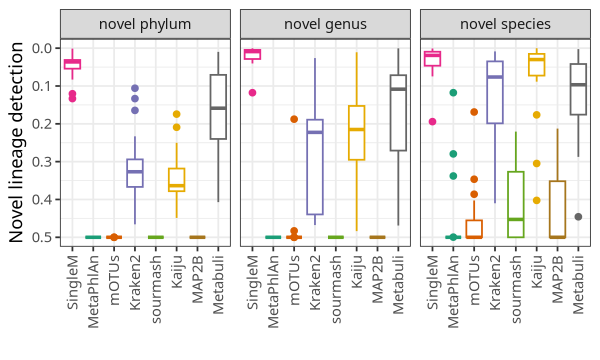

In [15]:
options(repr.plot.width=5, repr.plot.height=3)
qplot(data=novelty_benchmark_results[rank=='kingdom' & novelty_category_novel %in% c('novel phylum','novel genus','novel species')], xlab='', tool2, value, geom='boxplot', colour=tool2, ylab='Novel lineage detection')+facet_grid(.~novelty_category_novel)+theme(legend.position='none') +scale_color_manual(breaks=tools2_order, values=my_colours)+scale_y_reverse() +theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5))
# ggsave('novel_lineage_detection.svg', width=5, height=3)

# Read CAMI benchmark

In [16]:
cami_results = fread('3_cami2_marine/accuracy_results.csv',sep='\t')
cami_results[0:3]

tool,community,rank,metric,value
<chr>,<chr>,<chr>,<chr>,<dbl>
singlem,marine0,kingdom,Bray-Curtis distance,0.001003460
singlem,marine0,phylum,Bray-Curtis distance,0.007422594
singlem,marine0,class,Bray-Curtis distance,0.009349926


In [17]:
cami_results[, tool2 := name_to_publication_name(tool)]
cami_results[, rank := factor(rank, levels=orders)]

In [18]:
cami_results[rank=='species' & metric %in% c('F1 score','Completeness','Bray-Curtis distance'), mean(value), by=list(tool,metric)]

tool,metric,V1
<chr>,<chr>,<dbl>
singlem,Bray-Curtis distance,0.16755522
singlem,Completeness,0.57128045
singlem,F1 score,0.71576100
metaphlan,Bray-Curtis distance,0.08452814
metaphlan,Completeness,0.90780693
metaphlan,F1 score,0.92575106
kraken,Bray-Curtis distance,0.20172044
kraken,Completeness,0.99391726
kraken,F1 score,0.33698593


# Read bench 4 results

In [19]:
bench4 = fread('4_complex_and_novel/accuracy_results.csv',sep=',')
bench4[, tool2 := name_to_publication_name(tool)]
bench4[0:3]

tool,sample,known,rank,metric,value,tool2
<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<fct>
singlem,marine0,0,kingdom,Bray-Curtis distance,0.001875821,SingleM
singlem,marine0,0,phylum,Bray-Curtis distance,0.015305700,SingleM
singlem,marine0,0,class,Bray-Curtis distance,0.017625411,SingleM


In [20]:
bench4[, median := median(value), by=.(tool2,rank,metric,known)]

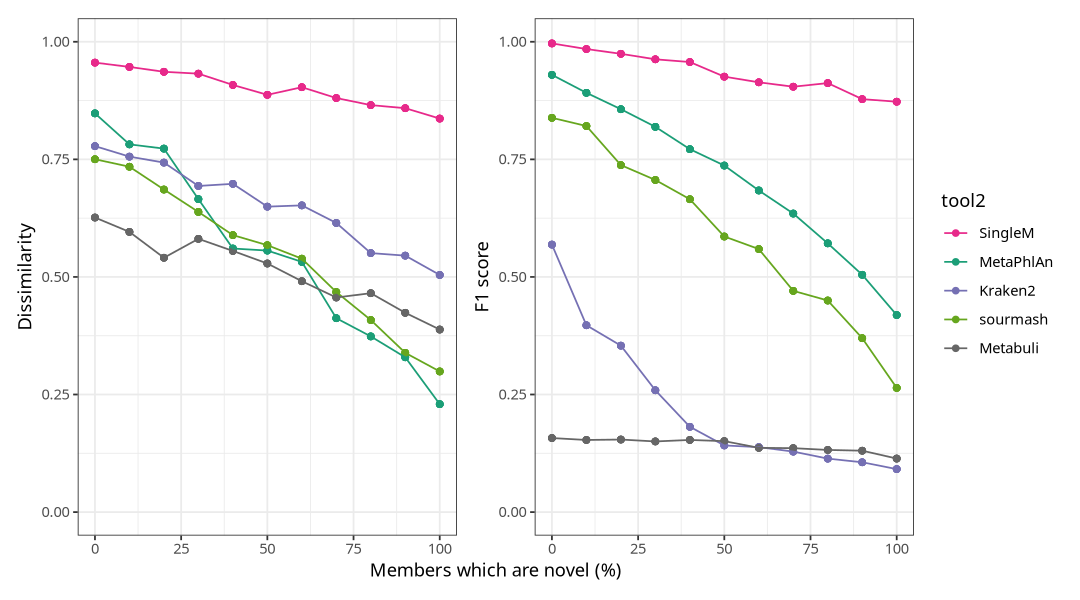

In [21]:
# no legend
bench4_bc = qplot(data=bench4[metric=='Bray-Curtis distance'][rank=='genus' & tool %in% correct_taxonomy_tools], known, 1-median, colour=tool2)+geom_line()+ylab('Dissimilarity')+xlab('Members which are novel (%)')+ylim(0,1)+scale_colour_manual(breaks=tools2_order, values=my_colours)+theme(legend.position='none')

bench4_f1 = qplot(data=bench4[metric=='F1 score'][rank=='genus' & tool %in% correct_taxonomy_tools], known, median, colour=tool2)+geom_line()+ylab('F1 score')+xlab('Members which are novel (%)')+ylim(0,1)+theme(legend.position='none')+scale_colour_manual(breaks=tools2_order, values=my_colours)+theme(legend.position='none')

options(repr.plot.width=9, repr.plot.height=5)
bench4_bc + bench4_f1 +theme(legend.position='right') +
  plot_layout(axis_titles = "collect")

ggsave('bench4.svg', width=9, height=5)

In [22]:
cami_results[rank %in% c('species','genus') & metric=='Bray-Curtis distance' & tool=='metabuli']

tool,community,rank,metric,value,tool2
<chr>,<chr>,<fct>,<chr>,<dbl>,<fct>
metabuli,marine0,genus,Bray-Curtis distance,0.2003884,Metabuli
metabuli,marine0,species,Bray-Curtis distance,0.2509231,Metabuli
metabuli,marine1,genus,Bray-Curtis distance,0.1898251,Metabuli
metabuli,marine1,species,Bray-Curtis distance,0.2350597,Metabuli
metabuli,marine2,genus,Bray-Curtis distance,0.1954146,Metabuli
metabuli,marine2,species,Bray-Curtis distance,0.2371942,Metabuli
metabuli,marine3,genus,Bray-Curtis distance,0.1854360,Metabuli
metabuli,marine3,species,Bray-Curtis distance,0.2368679,Metabuli
metabuli,marine4,genus,Bray-Curtis distance,0.1814703,Metabuli


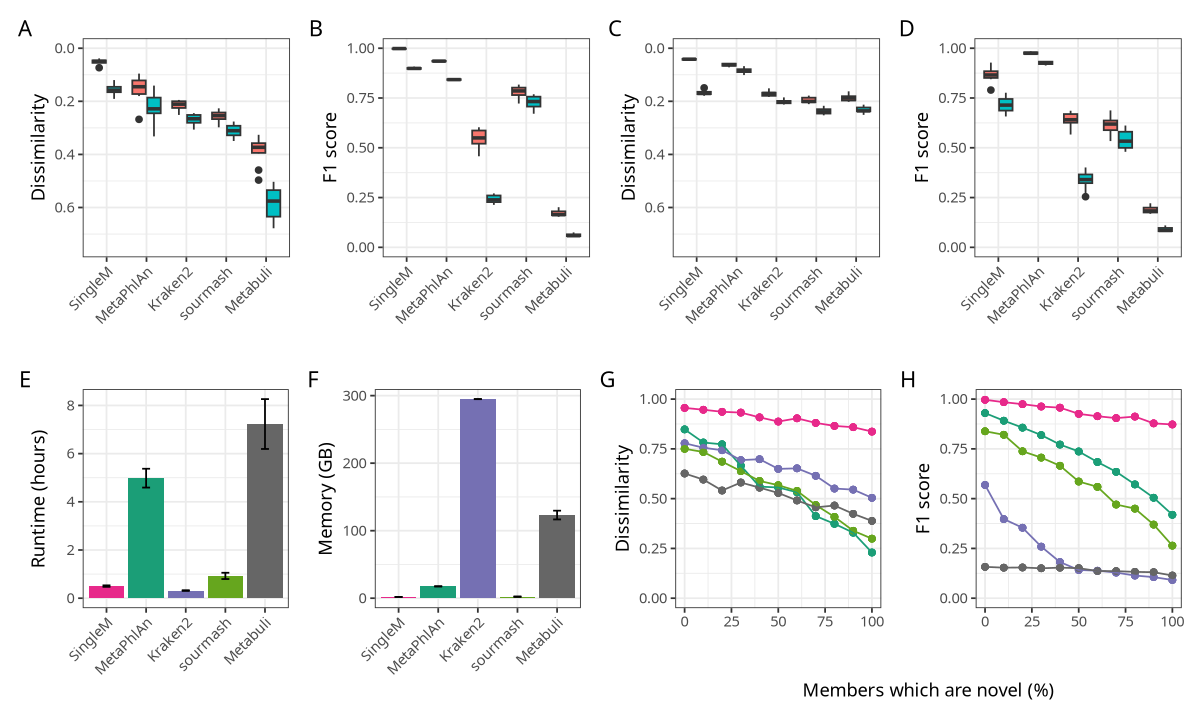

In [23]:
# f1/bray x rank x tool x community
marine[, tool2 := name_to_publication_name(tool)]
marine_no_metabuli = marine[tool != 'metabuli']

runtimes2 = runtimes[,.(mins=mean(cpu_time/60), max_rss=mean(max_rss/1000), min_sd=sd(cpu_time/60), max_rss_sd=sd(max_rss/1000)), by=tool2]

bc_max = 0.75#0.4
f1_min = 0


# plot31 = qplot(data=marine_no_metabuli[rank %in% c('species','genus') & metric=='Bray-Curtis distance'], xlab='', ylim=c(0.4,0), tool2, value, geom='boxplot', fill=rank, ylab='Dissimilarity') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_color_manual(breaks=tools2_order, values=my_colours)

# novel_strains_f1 = qplot(data=marine_no_metabuli[rank %in% c('species','genus') & metric=='F1 score'], xlab='', tool2, value, geom='boxplot', fill=rank, ylab='F1 score') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_color_manual(breaks=tools2_order, values=my_colours)


# plot32 = qplot(data=runtimes2[tool2 != 'Metabuli'][tool2 %in% correct_taxonomy_tools_publication_names], xlab='', tool2, mins/60, geom='col', fill=tool2, ylab='Runtime (hours)') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_fill_manual(breaks=tools2_order, values=my_colours)+geom_errorbar(aes(ymin=mins/60-min_sd/60, ymax=mins/60+min_sd/60), width=0.2)

# plot33 = qplot(data=runtimes2[tool2 != 'Metabuli'][tool2 %in% correct_taxonomy_tools_publication_names], xlab='', tool2, max_rss, geom='col', fill=tool2, ylab='Memory (GB)') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_fill_manual(breaks=tools2_order, values=my_colours)+geom_errorbar(aes(ymin=max_rss-max_rss_sd, ymax=max_rss+max_rss_sd), width=0.2)


# # [tool != 'metabuli']
# cami_bc = qplot(data=cami_results[tool != 'metabuli'][rank %in% c('species','genus') & metric=='Bray-Curtis distance'], x=tool2, y=value, fill=rank, geom='boxplot', ylim=c(0.33,0)) +theme(legend.position='none')+ylab('Dissimilarity')+xlab('') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')

# cami_f1 = qplot(data=cami_results[tool != 'metabuli'][rank %in% c('species','genus') & metric=='F1 score'], x=tool2, y=value, fill=rank, geom='boxplot')+ylab('F1 score')+xlab('') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')


# # Remove metabuli
# bench4_bc = qplot(data=bench4[tool != 'metabuli'][metric=='Bray-Curtis distance'][rank=='genus' & tool %in% correct_taxonomy_tools], known, 1-median, colour=tool2)+geom_line()+ylab('Dissimilarity')+xlab('Members which are novel (%)')+ylim(0,1)+scale_colour_manual(breaks=tools2_order, values=my_colours)+theme(legend.position='none')

# bench4_f1 = qplot(data=bench4[tool != 'metabuli'][metric=='F1 score'][rank=='genus' & tool %in% correct_taxonomy_tools], known, median, colour=tool2)+geom_line()+ylab('F1 score')+xlab('Members which are novel (%)')+ylim(0,1)+theme(legend.position='none')+scale_colour_manual(breaks=tools2_order, values=my_colours)+theme(legend.position='none')


plot31 = qplot(data=marine[rank %in% c('species','genus') & metric=='Bray-Curtis distance'], xlab='', tool2, value, geom='boxplot', fill=rank, ylab='Dissimilarity') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_color_manual(breaks=tools2_order, values=my_colours)# , ylim=c(0.4,0)

novel_strains_f1 = qplot(data=marine[rank %in% c('species','genus') & metric=='F1 score'], xlab='', tool2, value, geom='boxplot', fill=rank, ylab='F1 score') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_color_manual(breaks=tools2_order, values=my_colours)


plot32 = qplot(data=runtimes2[tool2 %in% correct_taxonomy_tools_publication_names], xlab='', tool2, mins/60, geom='col', fill=tool2, ylab='Runtime (hours)') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_fill_manual(breaks=tools2_order, values=my_colours)+geom_errorbar(aes(ymin=mins/60-min_sd/60, ymax=mins/60+min_sd/60), width=0.2)

plot33 = qplot(data=runtimes2[tool2 %in% correct_taxonomy_tools_publication_names], xlab='', tool2, max_rss, geom='col', fill=tool2, ylab='Memory (GB)') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')+scale_fill_manual(breaks=tools2_order, values=my_colours)+geom_errorbar(aes(ymin=max_rss-max_rss_sd, ymax=max_rss+max_rss_sd), width=0.2)


# [tool != 'metabuli']
cami_bc = qplot(data=cami_results[rank %in% c('species','genus') & metric=='Bray-Curtis distance'], x=tool2, y=value, fill=rank, geom='boxplot') +theme(legend.position='none')+ylab('Dissimilarity')+xlab('') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')#, ylim=c(0.3,0)

cami_f1 = qplot(data=cami_results[rank %in% c('species','genus') & metric=='F1 score'], x=tool2, y=value, fill=rank, geom='boxplot')+ylab('F1 score')+xlab('') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')


# Remove metabuli
bench4_bc = qplot(data=bench4[metric=='Bray-Curtis distance'][rank=='genus' & tool %in% correct_taxonomy_tools], known, 1-median, colour=tool2)+geom_line()+ylab('Dissimilarity')+xlab('Members which are novel (%)')+ylim(0,1)+scale_colour_manual(breaks=tools2_order, values=my_colours)+theme(legend.position='none')

bench4_f1 = qplot(data=bench4[metric=='F1 score'][rank=='genus' & tool %in% correct_taxonomy_tools], known, median, colour=tool2)+geom_line()+ylab('F1 score')+xlab('Members which are novel (%)')+ylim(0,1)+theme(legend.position='none')+scale_colour_manual(breaks=tools2_order, values=my_colours)+theme(legend.position='none')

options(repr.plot.width=10, repr.plot.height=6)
((plot31+ylim(bc_max,0)) + (novel_strains_f1+ylim(f1_min,1)) + (cami_bc+ylim(bc_max,0)) + (cami_f1+ylim(f1_min,1)) + plot_layout(nrow=1)) / 
    (plot32 + plot33 + bench4_bc + bench4_f1 + plot_layout(nrow=1, axis_titles = "collect")) + plot_annotation(tag_levels = list(c('A','B','C','D','E','F','G','H')))

# ggsave('fig2new.svg', width=10, height=6)


In [24]:
cami_results
# cami_bc = 
bc_max
# qplot(data=cami_results[rank %in% c('species','genus') & metric=='Bray-Curtis distance'], x=tool2, y=value, fill=rank, geom='boxplot') +theme(legend.position='none')+ylab('Dissimilarity')+xlab('') + theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none')#+ylim(bc_max,0)#, ylim=c(0.3,0)

tool,community,rank,metric,value,tool2
<chr>,<chr>,<fct>,<chr>,<dbl>,<fct>
singlem,marine0,kingdom,Bray-Curtis distance,0.001003460,SingleM
singlem,marine0,phylum,Bray-Curtis distance,0.007422594,SingleM
singlem,marine0,class,Bray-Curtis distance,0.009349926,SingleM
singlem,marine0,order,Bray-Curtis distance,0.018814001,SingleM
singlem,marine0,family,Bray-Curtis distance,0.025485587,SingleM
singlem,marine0,genus,Bray-Curtis distance,0.039697274,SingleM
singlem,marine0,species,Bray-Curtis distance,0.149309468,SingleM
singlem,marine0,phylum,Shannon diversity,1.527000246,SingleM
singlem,marine0,phylum,Shannon equitability,0.487004644,SingleM


[1] 0.75

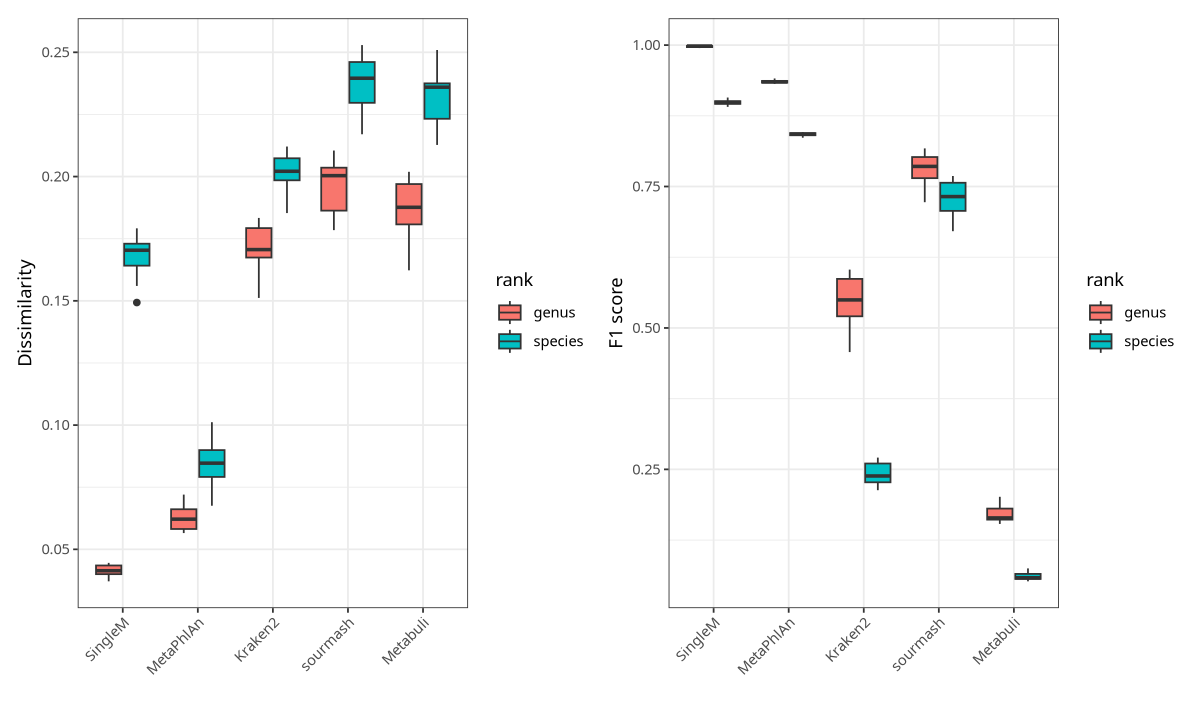

In [25]:
# And another to get the legend
cami_bc_legend = cami_bc+theme(legend.position='right')

novel_strains_f1_legend = novel_strains_f1+theme(legend.position='right')

cami_bc_legend + novel_strains_f1_legend
ggsave('fig2new_legend.svg', width=10, height=6)


  SingleM MetaPhlAn     mOTUs   Kraken2  sourmash     Kaiju     MAP2B  Metabuli 
        0         0         0         3         0         0         0        20 


  SingleM MetaPhlAn     mOTUs   Kraken2  sourmash     Kaiju     MAP2B  Metabuli 
        0         0         0         0         0         0         0         0 

Warning message:
“Removed 23 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


Warning message:
“Removed 23 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


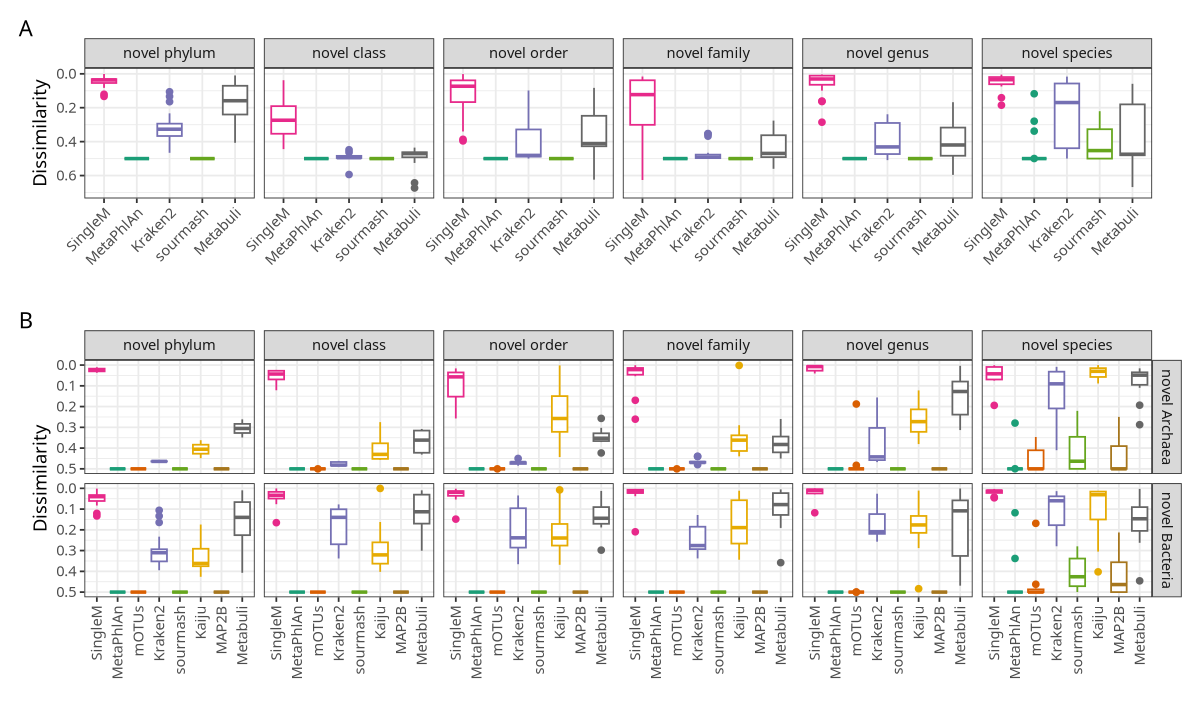

In [26]:
plot1 = qplot(data=novelty_benchmark_results[rank=='kingdom'], xlab='', tool2, value, geom='boxplot', colour=tool2, ylab='Dissimilarity')+facet_grid(kingdom~novelty_category_novel)+theme(legend.position='none') +scale_color_manual(breaks=tools2_order, values=my_colours) +theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5))+scale_y_reverse()

plot2_max_bc = 0.7

plot2 = qplot(data=novelty_benchmark_results[tool %in% correct_taxonomy_tools][rank==orders[as.numeric(novelty_category)-1]], colour=tool2, ylab='Dissimilarity', tool2, value, xlab='', geom='boxplot')+facet_grid(.~novelty_category_novel)+theme(axis.text.x = element_text(angle = 45, hjust = 1))+theme(legend.position='none') +scale_color_manual(breaks=tools2_order, values=my_colours)+ylim(plot2_max_bc,0)

# Which tools have number < the min? ?
table(novelty_benchmark_results[tool %in% correct_taxonomy_tools][rank==orders[as.numeric(novelty_category)-1]][value > plot2_max_bc]$tool2)
table(novelty_benchmark_results[rank=='kingdom'][value > 0.5]$tool2)

plot2 / plot1 + 
  plot_annotation(tag_levels = list(c('A','B')))+
  plot_layout(heights = c(1.1,2))# & theme(plot.tag=element_text(vjust=-1.5))
ggsave('fig3new.svg', width=7, height=6)